# MNIST Handwritten Digits Image Classification Task

@author: Rick Qiu (2021)

<span style="color:red">NOTE: </span> The model training may take about 1 hour on CPU. Recommend to use a GPU which is 20x faster than a CPU.

The ConvNet model is LeNet-5, a pioneering 7 layers Convolutional Neural Network by LeCun et al. in 1998.

The MNIST training data set can be downnloaded from Kaggle.The train.csv file contains gray-scale images of hand-written digits, from zero through nine. Each image has 28 pixels in height and 28 pixels in width. The pixel-value is an integer between 0 and 255, inclusive.

The data set has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

**Resources**

Yann LeCun, Leon Bottou, Yoshua Bengio, and Patrick Haffner (1998), Gradient-Based Learning Applied to Document (http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)

MNIST("Modified National Institute of Standards and Technology") handwritten digits [dataset](https://www.kaggle.com/c/digit-recognizer/data) from Kaggle

## LeNet-5 Architecture


LeNet-5 is a classic Convolutional Neural Network by LeCun et al.[1] in 1998. It comprises 7 layers (excluding the input layer). Layer 1 is a Convolutional layer, then followed by a Subsampling layer as Layer 2. Layer 3 is another Convolutional layer, then followed by another Subsampling layer as Layer 4. After the second Subsampling layer, there are 2 fully connected feed-forward neural networks Layer 5 and Layer 6. Layer 7 is the output layer.

<img src="image/lenet5.png" alt="LeNet-5" height="178" width="625"> 


#### Layer 1: Convolutional layer
Input: 32x32x1 $\quad Conv: f=5x5, s=1, c=6\quad$ Output: 28x28x6 $\quad$ Weights:5 x 5 x 6 + 6 = 156
#### Layer 2: Pooling layer
Input: 28x28x6 $\quad Pooling: f=2, s=2 \quad$ Output:14x14x6
#### Layer 3: Convolutional layer
Input: 14x14x6 $\quad Conv: f=5x5, s=1, c=16\quad$ Output:10x10x16 $\quad$ Weights: 5 x 5 x 16 x 6 + 16 = 2416
#### Layer 4: Pooling layer
Input: 10x10x16 $\quad Pooling: f=2, s=2 \quad$ Output:5x5x16
#### Layer 5: Fully Connected layer
Input:5x5x16 $\quad Activation: a_{n}^{[5]}=120 \quad$ Output:1x120
#### Layer 6: Fully Connected layer
Input:120 $\quad Activation: a_{n}^{[L-1]}=84 \quad$ Output:1x84
#### Layer 7:Output layer
Input:84 $\quad Activation: a_{n}^{[L]}=10 \quad$ Output:1x10

## Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import preprocessing

from tensorflow import keras 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import ZeroPadding2D, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
tf.__version__

'2.4.0'

In [2]:
# Load data from CSV file
#df = pd.read_csv('/content/drive/MyDrive/data/train.csv')
df = pd.read_csv('data/train.csv')
dataset = df.values

print("         Dataframe Info")
print("----------------------------------------")
df.info()
print("----------------------------------------")
print()
print("         Dataset Info")
print("----------------------------------------")
print(type(dataset))
print("dimension: %s" % str(dataset.shape))
print("----------------------------------------")

         Dataframe Info
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
----------------------------------------

         Dataset Info
----------------------------------------
<class 'numpy.ndarray'>
dimension: (42000, 785)
----------------------------------------


Find null and missing values

In [5]:
n_nan = df.isnull().sum().sum()
print("Number of NaN and missing values: %d" % n_nan)
print("Dataset datatype: %s" % dataset.dtype)

Number of NaN and missing values: 0
Dataset datatype: int64


The data set is good. It does not have any null and missing values.

The data set will be split to 80% for training, the remaining 20% will be split to 10% for validation and 10% for test.

In [6]:
# Extract pixel values per image
X = dataset[:,1:]
# Extract labels
y = dataset[:,0]

# Split dataset into train, validation and test (80:10:10) 
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

In [7]:
X_train.shape

(33600, 784)

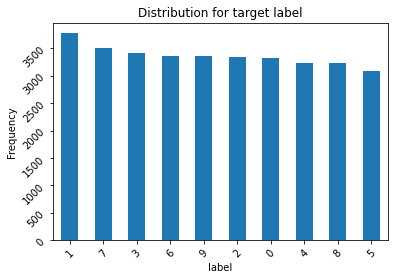

In [8]:
# Plot the frequency table for each digit in training dataset
freq_df = pd.DataFrame(y_train, columns=['label'])
frequency_table = freq_df['label'].value_counts(ascending=False)
frequency_table.plot(kind='bar')
plt.title('Distribution for target label')
plt.xlabel('label')
plt.ylabel('Frequency')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()


We are to display 50 images from the training dataset and add a label on top of each image.

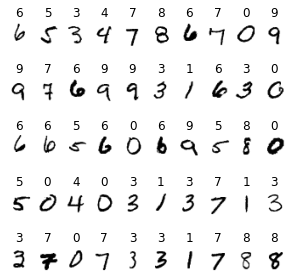

In [9]:
def display_images(images, labels, n_images):
    """Display images and labels """
    plt.figure(figsize=(5,5))
    m = np.ceil(n_images/10)

    for i in range(n_images):
        plt.subplot(m,10,1+i)
        plt.title(labels[i])
        plt.axis('off')
        plt.imshow(images[i].reshape(28,28), cmap=plt.cm.binary)

# Display 50 original images and labels
display_images(X_train[0:50,:], y_train[0:50], 50)


### Feature scaling

In [10]:
# features scalling
scaler = preprocessing.MinMaxScaler().fit(X_train)
#scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Padding X and One-hot encoding y
The LeNet-5 Input is a 32x32 gray-scale image. So, we add 2 pixels with zeros on each side of the image to make a 28x28 image to 32x32 image. Padding the border of an image has the effect of not losing information near the borders after the first convolution operation because an output image has the same size as the original image size 28x28.  

One-hot encoding for a label value 3 is to create a vector $[0,0,0,1,0,0,0,0,0,0]$ to represent 3, which means that only the number at index 3 is one, others are all zeros.

In [11]:
# Reshape the training, validation and test dataset
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 28, 28, 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 28, 28, 1)
X_val_scaled = X_val_scaled.reshape(X_val_scaled.shape[0], 28, 28, 1)

# Padding the images by 2 pixels to make 32x32 images
X_train_scaled = np.pad(X_train_scaled, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test_scaled = np.pad(X_test_scaled, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_val_scaled = np.pad(X_val_scaled, ((0,0),(2,2),(2,2),(0,0)), 'constant')

# Label One-hot encoding
y_train = to_categorical(y_train)
y_val= to_categorical(y_val)

## Modelling

In [12]:
def cnn_model():
    model = Sequential()
    
    # Layer 1
    # Convolutional Layer 1
    model.add(Conv2D(filters=6, kernel_size=5, strides=1, 
                     kernel_initializer='glorot_normal', input_shape=(32,32,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    # Layer 2
    # Pooling layer 1
    model.add(MaxPooling2D(pool_size=2,strides=2))
    
    # Layer 3
    # Convolutional Layer 2
    model.add(Conv2D(filters =16, kernel_size=5, strides=1, 
                     kernel_initializer='glorot_normal', input_shape=(14,14,6)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    # Layer 4
    # Pooling Layer 2
    model.add(MaxPooling2D(pool_size=2, strides=2))
    
    # Flatten
    model.add(Flatten())
   
    # Layer 5        
    # Fully connected layer 1
    model.add(Dense(units=120, kernel_initializer='glorot_normal', 
                    activity_regularizer=tf.keras.regularizers.l2(0.001)))

    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    # Layer 6          
    # Fully connected layer 2
    model.add(Dense(units=84, kernel_initializer='glorot_normal', 
                    activity_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    # Layer 7
    # Output Layer
    model.add(Dense(units=10, activation ='softmax'))
   
    return model

model = cnn_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 6)         24        
_________________________________________________________________
activation (Activation)      (None, 28, 28, 6)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 10, 10, 16)        0

## Model Training


In [13]:
# Specify the optimizer
opt = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

# Create the checkpoint to bag the best model
checkpointer = ModelCheckpoint(filepath="mnist_model.h5",
                               verbose=0,
                               save_best_only=True)

# Fit the model
history = model.fit(X_train_scaled, y_train, 
                    validation_data=(X_val_scaled, y_val),
                    callbacks=[checkpointer],
                    batch_size = 128,
                    epochs = 100, 
                    verbose = 1)

Epoch 1/100
263/263 [==============================] - 8s 7ms/step - loss: 1.4620 - accuracy: 0.6020 - val_loss: 0.4422 - val_accuracy: 0.9395
Epoch 2/100
263/263 [==============================] - 1s 5ms/step - loss: 0.4167 - accuracy: 0.9240 - val_loss: 0.1621 - val_accuracy: 0.9764
Epoch 3/100
263/263 [==============================] - 1s 5ms/step - loss: 0.2646 - accuracy: 0.9536 - val_loss: 0.1379 - val_accuracy: 0.9798
Epoch 4/100
263/263 [==============================] - 1s 5ms/step - loss: 0.2013 - accuracy: 0.9627 - val_loss: 0.1062 - val_accuracy: 0.9840
Epoch 5/100
263/263 [==============================] - 1s 5ms/step - loss: 0.1610 - accuracy: 0.9684 - val_loss: 0.0954 - val_accuracy: 0.9836
Epoch 6/100
263/263 [==============================] - 1s 5ms/step - loss: 0.1369 - accuracy: 0.9737 - val_loss: 0.0857 - val_accuracy: 0.9843
Epoch 7/100
263/263 [==============================] - 1s 5ms/step - loss: 0.1189 - accuracy: 0.9753 - val_loss: 0.0709 - val_accuracy: 0.9867

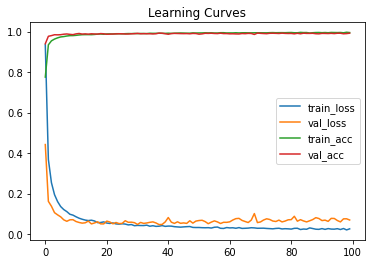

In [14]:
def plot_loss_acc(history):
    """Plot accuracy and loss across the different epochs """
    # Plot loss
    plt.plot(history.history["loss"],label="train_loss")
    plt.plot(history.history["val_loss"],label="val_loss")
    # Plot Accuracy
    plt.plot(history.history["accuracy"],label="train_acc")
    plt.plot(history.history["val_accuracy"],label="val_acc")
    plt.title('Learning Curves')
    plt.legend()
    plt.show()

plot_loss_acc(history)

## Performance Analysis

In [15]:
# Load the trained model
net = load_model("mnist_model.h5")

In [16]:
# Classification report
class_names = ['class 0','class 1','class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']

# Test Accuracy
y_pred = net.predict(tf.dtypes.cast(X_test_scaled, tf.float16))

# Convert one-hot vectors to 0 or 1 label
y_hat = np.argmax(y_pred, axis = 1)

print(classification_report(y_test, y_hat, target_names=class_names))

              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00       405
     class 1       0.99      0.99      0.99       455
     class 2       1.00      0.99      0.99       424
     class 3       0.99      0.99      0.99       448
     class 4       0.99      0.97      0.98       388
     class 5       1.00      0.99      1.00       364
     class 6       0.98      1.00      0.99       389
     class 7       0.99      0.99      0.99       457
     class 8       0.98      0.99      0.99       442
     class 9       0.99      1.00      0.99       428

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200



## Error Analysis

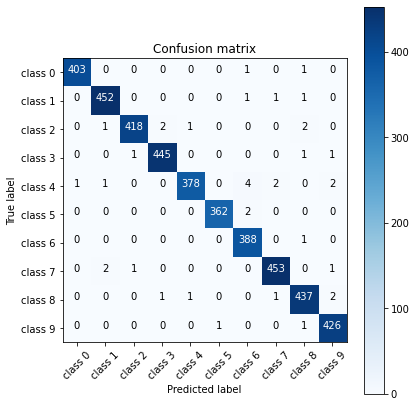

In [17]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat)
np.set_printoptions(precision=2)

# Plot confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')

plt.show()

Misclassifed images
--------------------------------
Total:   38


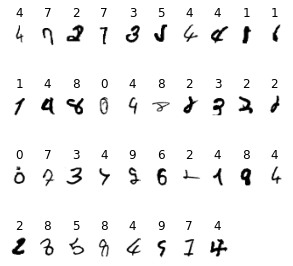

In [18]:
# Display misclassifed images and true labels
indices_miscls = [idx for idx, elem in enumerate(zip(y_test.flatten(), y_hat.flatten())) if elem[0] != elem[1]]
images_miscls = X_test[indices_miscls,:]
labels_miscls = y_test[indices_miscls]
display_images(images_miscls, labels_miscls, len(labels_miscls))
print("Misclassifed images")
print("--------------------------------")
print("Total:   %d" % len(indices_miscls))